**Table of contents**<a id='toc0_'></a>    
- 1. [Correlation distance in Cascadia   ](#toc1_)    
- 2. [Load data  ](#toc2_)    
- 3. [Compute correlation distance matrix ](#toc3_)    
- 4. [Plot for the paper](#toc4_)    
- 5. [Time-based measure of synchronization](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Correlation distance in Cascadia    [&#128285;](#toc0_)

In [2]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from stats import cross_corr

In [3]:
mag_min = 1.8

# 2. <a id='toc2_'></a>Load data   [&#128285;](#toc0_)
Directly from pre-processed catalogs — with earthquake counts and modeled depths.

In [4]:
day0 = pd.Timestamp('2009-08-01')

In [5]:
# Load tremor
trm = pd.read_csv('data/cascadia/processed/casc_trm_0809_0624_zb19_trim_eqdist_mc{:.1f}.csv'.format(mag_min), parse_dates=['date'])
trm['day'] = (trm.date - day0) / np.timedelta64(1, 'D')

In [6]:
# Load earthquakes
eq = pd.read_csv('data/cascadia/processed/casc_eqmc{:.1f}_0809_0624_trim_eqdist.csv'.format(mag_min))

strip = lambda x: str.removesuffix(x, '+00:00')
eq['date'] = list(map(strip, eq.date))
eq['date'] = pd.to_datetime(eq.date, format='mixed')

/Users/gaspard/mambaforge/envs/eqvlfe/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


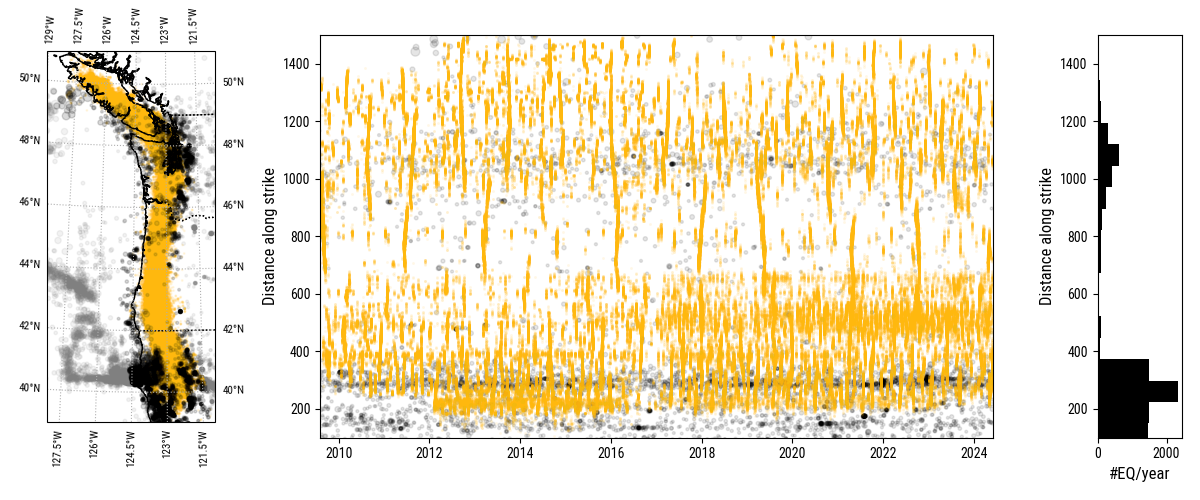

In [7]:
# Overview
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 3, width_ratios=[2, 8, 1])

# Map
crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())

ax = fig.add_subplot(gs[0], projection=crs)
min_lon, max_lon = -128, -121
min_lat, max_lat = 39, 51
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, color='.7', zorder=0)
ax.add_feature(cfeature.STATES, linestyle=':', linewidth=1)
gl = ax.gridlines(draw_labels=True, ls=':', zorder=-1)
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

ax.scatter(trm.lon, trm.lat, s=1, c=[to_rgba('C2', .1) for ii in range(len(trm))], transform=ccrs.PlateCarree())
ax.scatter(eq.lon, eq.lat, s=eq.mag**2, c=[to_rgba('.5', .1) for ii in range(len(eq))], transform=ccrs.PlateCarree(), zorder=-1)
ax.scatter(eq.lon[eq.in50km], eq.lat[eq.in50km], s=eq.mag[eq.in50km]**2, c=[to_rgba('k', .1) for ii in range(len(eq[eq.in50km]))], transform=ccrs.PlateCarree(), zorder=1)

# Time-strike
ax = fig.add_subplot(gs[1])
ax.set_ylabel('Distance along strike')
ax.set_xlim(trm.date.min(), trm.date.max())
ax.set_ylim(100, 1500)

ax.plot(trm.date, trm.xf, ls='', marker='o', mfc=to_rgba('C2', .1), mec=[0,0,0,0], ms=2)
indicator = eq.in50km & (eq.mag > 2)
ax.scatter(eq.date[indicator], eq.xf[indicator], c=[to_rgba('k', .1) for ii in range(indicator.sum())], s=eq.mag[indicator]**2, zorder=1)

# --> Find where longitudes are along strike
# coords = ccrs.PlateCarree().transform_points(crs, eq.x[0]*1000, eq.y[0]*1000)
# lon = coords[:, 0]
# lat = coords[:, 1]

# coords = ccrs.PlateCarree().transform_points(crs, np.array(X)*1000, np.array(Y)*1000)
# lon = coords[:, 0]
# lat = coords[:, 1]

# lats = np.array([40, 42, 44, 46, 48, 50])

# ilats = np.abs(lat[:, np.newaxis] - lats).argmin(axis=0)
# lats_along_strike = S[ilats]

# ax_lats = ax.twinx()
# ax_lats.set_ylim(ax.get_ylim())
# ax_lats.set_yticks(lats_along_strike)
# ax_lats.set_yticklabels([f'{lat:.0f}°N' for lat in lats])

# Earthquake activity
ax = fig.add_subplot(gs[2], sharey=ax)
ax.set_xlabel('#EQ/year')
ax.set_ylabel('Distance along strike')
ax.hist(eq.xf[eq.in50km], bins=20, orientation='horizontal', color='k')

plt.tight_layout()
plt.show()

# 3. <a id='toc3_'></a>Compute correlation distance matrix  [&#128285;](#toc0_)

In [8]:
# Make the matrix of cross-correlation — Parameters
# --> Define the spatial bins
dx_bin = 10  # in km, width of bin
xmin_bin = 200
xmax_bin = 1400
x_bin_edges = np.arange(xmin_bin, xmax_bin + dx_bin, dx_bin)

# --> Parameters for the temporal counts
delta = 1  # in days, width of the temporal bin to count tremor events

# --> Parameters for the correlation
norm = True
no_bias = True
look_both_ways = True  # to add the negative lags to the positive

# --> Minimum speed of communication to consider (affects where we look for maximum lag)
v_min = 3.5  # in km/day

In [12]:
# Make the matrix of cross-correlation — Computation (takes time, 30s for bins of 10 km, 1 day, 1000 km wide)
# --> Make the counts
count_time = np.arange(0, trm.day.max()+delta, delta)
counts = np.zeros((len(x_bin_edges)-1, len(count_time)-1))

for ii in range(len(x_bin_edges)-1):
    x_min = x_bin_edges[ii]
    x_max = x_bin_edges[ii+1]
    trm_in_bin = trm.xf.between(x_min, x_max)
    counts[ii, :] = np.histogram(trm[trm_in_bin].day.values, bins=count_time)[0]

# --> Compute the cross-correlation matrix
cc_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))
lag_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))

for ii in range(len(x_bin_edges)-1):
    print('{:d}/{:d}'.format(ii, len(x_bin_edges)-1), end='\r')
    for jj in range(len(x_bin_edges)-1):
        if jj <= ii:
            if ~np.any(counts[ii, :]) or ~np.any(counts[jj, :]):
                cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.nan
                lag_matrix[ii, jj] = lag_matrix[jj, ii] = np.nan
            else:
                cc, lag = cross_corr(counts[ii, :], counts[jj, :], delta, norm=norm, no_bias=no_bias)
                
                if look_both_ways:
                    cc = (cc + cc[::-1]) / 2
                    cc = cc[lag >= 0]
                    lag = lag[lag >= 0]
                
                in_window = np.abs(lag) <= abs((x_bin_edges[ii+1] + x_bin_edges[ii])/2 - (x_bin_edges[jj+1] + x_bin_edges[jj])/2) / v_min
                cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc[in_window])
                lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[in_window][np.argmax(cc[in_window])]

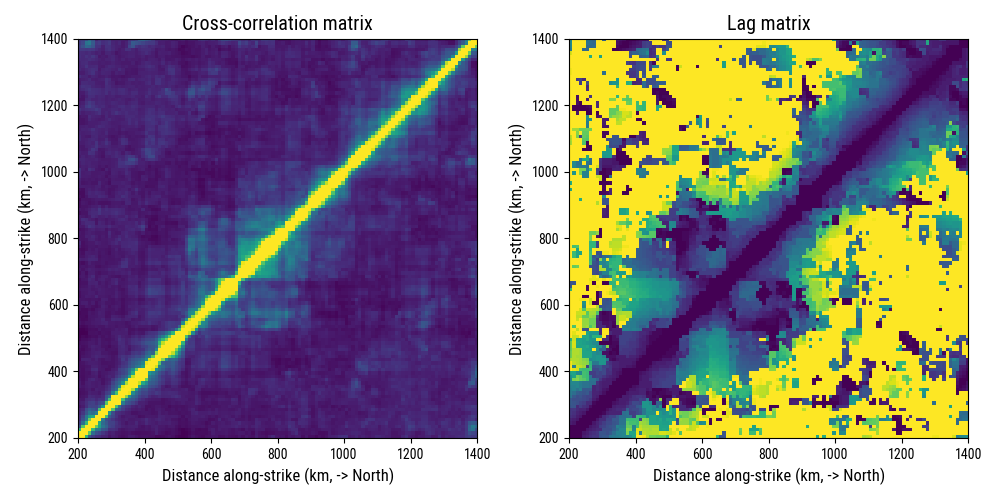

In [13]:
# Show the matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]

cax = ax.imshow(cc_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], vmax=.5, origin='lower')
ax.set_xlabel('Distance along-strike (km, -> North)')
ax.set_ylabel('Distance along-strike (km, -> North)')
ax.set_title('Cross-correlation matrix')

ax = axes[1]
cax = ax.imshow(lag_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], vmin=0, vmax=50, origin='lower')
ax.set_xlabel('Distance along-strike (km, -> North)')
ax.set_ylabel('Distance along-strike (km, -> North)')
ax.set_title('Lag matrix')

plt.tight_layout()
plt.show()

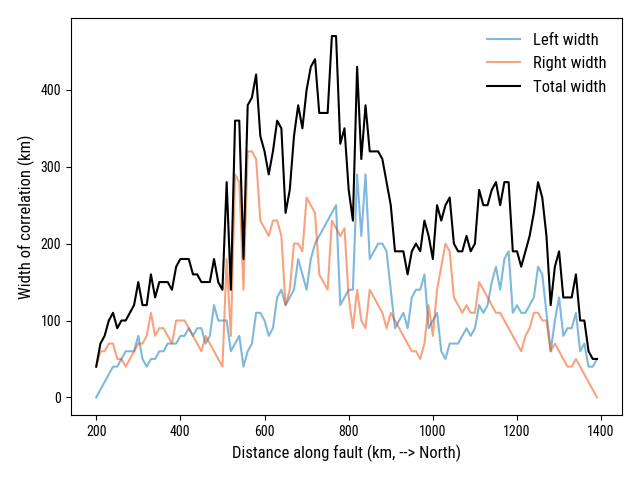

In [14]:
# Instead of fitting, just look how far you are above a threshold
threshold_cc = .07
left_width = []
right_width = []

for ii in range(len(x_bin_edges)-1):
    # Look right
    jj = ii
    while (jj < len(x_bin_edges)-1) and (cc_matrix[ii, jj] > threshold_cc):
        jj += 1
    right_width.append(x_bin_edges[jj-1] - x_bin_edges[ii])

    # Look left
    jj = ii
    while (jj >= 0) and (cc_matrix[ii, jj] > threshold_cc):
        jj -= 1
    left_width.append(x_bin_edges[ii] - x_bin_edges[jj+1])

left_width = np.array(left_width).astype(float)
right_width = np.array(right_width).astype(float)

# Remove wrong points
left_width[~np.any(counts, axis=1)] = np.nan
right_width[~np.any(counts, axis=1)] = np.nan

corr_length = np.array(left_width) + np.array(right_width)

# Show results
fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Width of correlation (km)')
ax.plot(x_bin_edges[:-1], left_width, '-', label='Left width', alpha=0.5)
ax.plot(x_bin_edges[:-1], right_width, '-', label='Right width', alpha=0.5)
ax.plot(x_bin_edges[:-1], corr_length, 'k-', label='Total width', ms=8)
ax.legend()
plt.tight_layout()
plt.show()

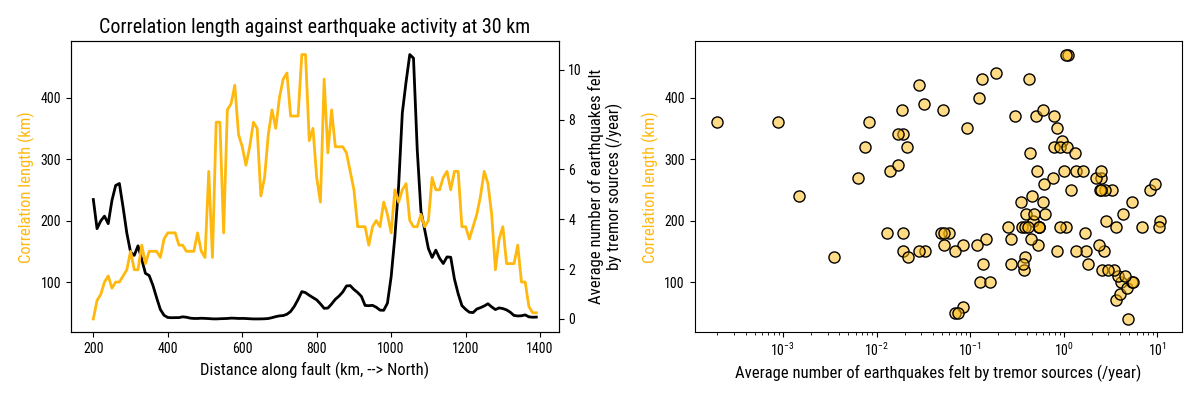

In [15]:
# Against earthquake activity
# --> Compute binned measure of earthquake activity
dists = [10, 20, 30, 50, 100]  # different distances in km

n_close_eq = {}
for dist in dists:
    n_close_eq[dist] = np.zeros(len(x_bin_edges)-1)
    for ii in range(len(x_bin_edges)-1):
        x_min = x_bin_edges[ii]
        x_max = x_bin_edges[ii+1]
        trm_in_bin = trm[trm.xf.between(x_min, x_max)]
        n_close_eq[dist][ii] = np.mean(trm_in_bin[f'n_eq_{dist}km'])

# Plot
chosen_dist = 30
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --> In space
ax = axes[0]
ax.set_title(f'Correlation length against earthquake activity at {chosen_dist} km')
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Correlation length (km)', color='C2')
ax.plot(x_bin_edges[:-1], corr_length, 'C2-', lw=2)

ax_eq = ax.twinx()
ax_eq.set_zorder(-10)
ax.set_facecolor('none')
ax_eq.set_ylabel('Average number of earthquakes felt\nby tremor sources (/year)', color='k')
ax_eq.plot(x_bin_edges[:-1], n_close_eq[chosen_dist], 'k-', lw=2)

# --> One against the other
ax = axes[1]
ax.set_xlabel('Average number of earthquakes felt by tremor sources (/year)')
ax.set_ylabel('Correlation length (km)', color='C2')
ax.plot(n_close_eq[chosen_dist], corr_length, 'o', ms=8, mec='k', mfc=to_rgba('C2', .5))
ax.set_xscale('log')

plt.tight_layout()
plt.show()

In [16]:
# Stats
from scipy.stats import linregress
n_eq = np.log10(n_close_eq[chosen_dist])
cc_d = corr_length

slope, intercept, r_value, p_value, std_err = linregress(n_eq, cc_d)
print('Slope:{:.2f}'.format(slope))
print('Error on slope (std): ±{:.2f}'.format(std_err))
print('Corellation coefficient:{:.2f}'.format(r_value))

SSres = np.sum((cc_d - (slope * n_eq + intercept))**2)  # sum of squares of residuals
SStot = np.sum((cc_d - np.mean(cc_d))**2)  # total sum of squares
R2 = 1 - SSres / SStot
print('Percentage of variance explained (R²): {:.1f}%'.format(100*R2))

Slope:nan
Error on slope (std): ±nan
Corellation coefficient:nan
Percentage of variance explained (R²): nan%


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_99901/3325350381.py:3: RuntimeWarning: divide by zero encountered in log10
  n_eq = np.log10(n_close_eq[chosen_dist])
/Users/gaspard/mambaforge/envs/eqvlfe/lib/python3.12/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


In [17]:
# Save results
import pickle
results = {'corr_length': corr_length, 'n_close_eq': n_close_eq, 'dists':dists, 'cc_thr':threshold_cc, 'dx':dx_bin, 'dt': delta}

path = 'results/casc_synch_mc{:.1f}_dx{:d}_cc{:.2f}.pkl'.format(mag_min, int(dx_bin), threshold_cc)
with open(path, 'wb') as f:
    pickle.dump(results, f)

# 4. <a id='toc4_'></a>Plot for the paper [&#128285;](#toc0_)

/Users/gaspard/mambaforge/envs/eqvlfe/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


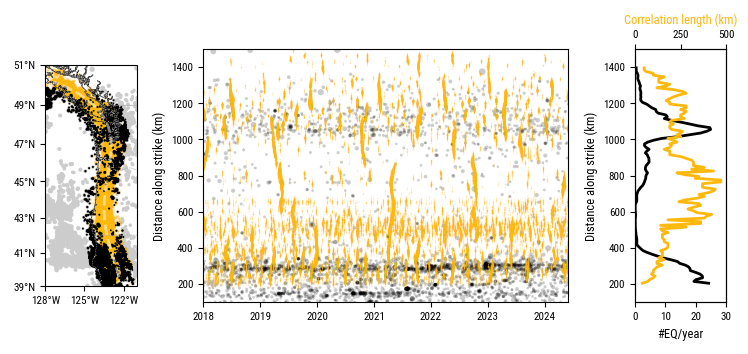

In [43]:
# Plot for paper
with plt.style.context('grl'):
    fig = plt.figure(figsize=np.array([19, 9])/2.54)
    gs = fig.add_gridspec(1, 3, width_ratios=[2, 8, 2])

    # Map
    # crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())
    crs = ccrs.Mercator()

    ax = fig.add_subplot(gs[0], projection=crs)
    min_lon, max_lon = -128, -121
    min_lat, max_lat = 39, 51
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    ax.coastlines(lw=.5)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=.5, color='.7', zorder=0)
    ax.add_feature(cfeature.STATES, linestyle=':', linewidth=.5, edgecolor='.7')

    ax.set_xticks(np.arange(min_lon, max_lon, 3), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(min_lat, max_lat+2, 2), crs=ccrs.PlateCarree())

    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    ax.scatter(trm.lon, trm.lat, s=1, c=[to_rgba('C2', .1) for ii in range(len(trm))], transform=ccrs.PlateCarree())
    ax.scatter(eq.lon, eq.lat, s=eq.mag**2/2, c=[to_rgba('.8', 1) for ii in range(len(eq))], transform=ccrs.PlateCarree(), zorder=-1)
    ax.scatter(eq.lon[eq.in50km], eq.lat[eq.in50km], s=eq.mag[eq.in50km]**2/2, c=[to_rgba('k', 1) for ii in range(len(eq[eq.in50km]))], transform=ccrs.PlateCarree(), edgecolor=[0,0,0,0], zorder=1)

    along_strike = pickle.load(open('data/cascadia/processed/along_strike.pkl', 'rb'))
    along_strike_lon = along_strike['lon'][(along_strike['s'] > 150) & (along_strike['s'] < 1500)]
    along_strike_lat = along_strike['lat'][(along_strike['s'] > 150) & (along_strike['s'] < 1500)]
    
    ax.plot(along_strike_lon, along_strike_lat, ls='--', lw=2, color=to_rgba('w', .5), transform=ccrs.PlateCarree(), zorder=10)

    # Time-strike
    ax = fig.add_subplot(gs[1])
    ax.set_ylabel('Distance along strike (km)')
    ax.set_xlim(trm.date.min(), trm.date.max())
    ax.set_xlim(np.datetime64('2018-01-01'), np.datetime64('2024-06-01'))
    ax.set_ylim(100, 1500)

    ax.plot(trm.date, trm.xf, ls='', marker='o', mfc=to_rgba('C2', .1), mec=[0,0,0,0], ms=1)
    indicator = eq.in50km & (eq.mag > mag_min)
    ax.scatter(eq.date[indicator], eq.xf[indicator], c=[to_rgba('k', .2) for ii in range(indicator.sum())], s=eq.mag[indicator]**2, zorder=1, edgecolor=[0,0,0,0])

    # Earthquake activity vs correlation length
    ax = fig.add_subplot(gs[2], sharey=ax)
    ax.set_ylabel('Distance along strike (km)')
    ax.set_xlabel('#EQ/year')
    ax.set_xlim(0, 30)
    ax.set_xticks([0, 10, 20, 30])

    chosen_dist = 50
    ax.plot(n_close_eq[chosen_dist], x_bin_edges[:-1] + dx_bin/2, 'k-', lw=2)

    ax_cc = ax.twiny()
    ax_cc.set_xlim(0, 500)
    ax_cc.set_xlabel('Correlation length (km)', color='C2')
    ax_cc.plot(corr_length, x_bin_edges[:-1] + dx_bin/2, 'C2-', lw=2)

    plt.tight_layout()
    plt.show()

# 5. <a id='toc5_'></a>Time-based measure of synchronization [&#128285;](#toc0_)

In [23]:
# Make the matrix of cross-correlation — Parameters
# --> Define the spatial bins
dx_bin = 10  # in km, width of bin
xmin_bin = 200
xmax_bin = 1400
x_bin_edges = np.arange(xmin_bin, xmax_bin + dx_bin, dx_bin)

q = 0.01

In [24]:
# Measure in each bin, what fraction of inter-event times represent q% of the total
episodicity = np.zeros(len(x_bin_edges)-1)
t0 = trm.day.min()
t1 = trm.day.max()

for ii in range(len(x_bin_edges)-1):
    # --> Select tremor
    x_min = x_bin_edges[ii]
    x_max = x_bin_edges[ii+1]
    trm_in_bin = trm.xf.between(x_min, x_max)
    
    # --> Get inter-event times in the bin
    trm_in_bin = trm[trm_in_bin].sort_values('day')
    inter_event_times = np.diff(trm_in_bin.day)  # in days
    inter_event_times = np.sort(inter_event_times)[::-1]
    
    episodicity[ii] = np.sum(inter_event_times[inter_event_times > np.quantile(inter_event_times, 1-q)]) / (t1 - t0)

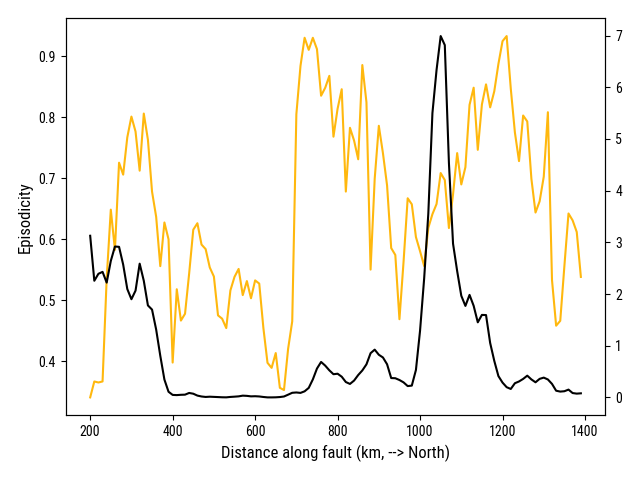

In [27]:
fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Episodicity')
ax.plot(x_bin_edges[:-1], episodicity, 'C2-', ms=8)
ax_ = ax.twinx()
ax_.plot(x_bin_edges[:-1], n_close_eq[chosen_dist], 'k-', ms=8)

plt.tight_layout()
plt.show()

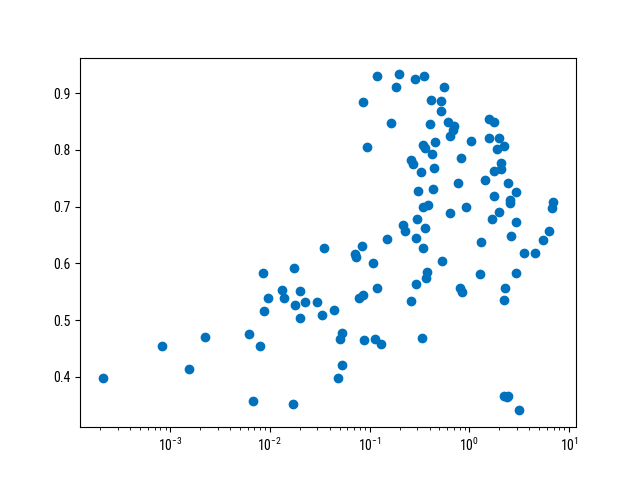

In [29]:
plt.figure()
plt.semilogx(n_close_eq[chosen_dist], episodicity, 'o')
plt.show()